In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from torchvision import transforms

from datasets import LoadData, ImageDataset

ds = LoadData('./data')
train_set, val_set, test_set = ds.train_test_split(test_size =0.1, random_state=1234)

In [2]:
train_df = train_set.merge(ds.load_image(), on = 'TCGA ID')
val_df = val_set.merge(ds.load_image(), on = 'TCGA ID')
test_df = test_set.merge(ds.load_image(), on = 'TCGA ID')

## Dataset

In [3]:
image_path = './data/all_st_patches_512'
SAMPLE_SIZE = 9
train_dataset = ImageDataset(dataframe = train_df, root_dir = image_path, sample_size = SAMPLE_SIZE,
                             transform = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                                             transforms.RandomVerticalFlip(0.5),
                                                             transforms.Resize(224),
                                                             transforms.ToTensor()]))

val_dataset = ImageDataset(dataframe = val_df, root_dir = image_path, sample_size = SAMPLE_SIZE,
                            transform = transforms.Compose([transforms.Resize(224),
                                                            transforms.ToTensor()]))

test_dataset = ImageDataset(dataframe = test_df, root_dir = image_path, sample_size = SAMPLE_SIZE,
                            transform = transforms.Compose([transforms.Resize(224),
                                                            transforms.ToTensor()]))

In [4]:
train_dataset[0]['image'].shape

torch.Size([9, 3, 224, 224])

## DataLoader

In [7]:
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [6]:
from models import PretrainNet

#device = torch.device('cpu')
pretrain_model = PretrainNet()
#pretrain_model.load_state_dict(torch.load('pre_cnn_model.pt', map_location=device))

In [7]:
from models import Model

model = Model(pretrain_model, sample_size =SAMPLE_SIZE)
total_params = sum(p.numel() for p in model.parameters())
print('Total Number of Parameters :', total_params)

Total Number of Parameters : 110104


In [8]:
#for name, param in model.named_parameters():
#    if param.requires_grad and 'pretrain_cnn_model' in name:
#        param.requires_grad = False

In [9]:
x = torch.randn(10, SAMPLE_SIZE, 3, 224, 224)
model(x).shape

torch.Size([10, 1])

## Train

In [10]:
from train import Trainer
from utils.utils import CoxLoss, lifelines_cindex

device = 'cuda:0'
model.to(device)

trainer = Trainer(model, train_loader, val_loader, criterion = CoxLoss, optimizer = optim.Adam,
                  epochs = 25, lr = 0.0001, l2 = 0.001, device = device)
trainer.fit()

  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

epoch: 1/25 
train_loss: 0.7132, train_cindex: 0.5766, train_mse: 536.6756, val_loss: 1.7378, val_cindex: 0.6043, val_mse: 232.9684


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

epoch: 2/25 
train_loss: 0.6706, train_cindex: 0.6371, train_mse: 538.5466, val_loss: 1.7364, val_cindex: 0.7002, val_mse: 224.9965


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

epoch: 3/25 
train_loss: 0.6726, train_cindex: 0.6583, train_mse: 544.7375, val_loss: 1.7327, val_cindex: 0.6933, val_mse: 227.1473


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

epoch: 4/25 
train_loss: 0.6532, train_cindex: 0.6541, train_mse: 542.5856, val_loss: 1.6825, val_cindex: 0.7055, val_mse: 226.6925


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

epoch: 5/25 
train_loss: 0.6513, train_cindex: 0.6422, train_mse: 543.4098, val_loss: 1.6963, val_cindex: 0.6933, val_mse: 248.2456


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

epoch: 6/25 
train_loss: 0.6475, train_cindex: 0.6606, train_mse: 543.7393, val_loss: 1.6709, val_cindex: 0.7002, val_mse: 230.0002


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

epoch: 7/25 
train_loss: 0.6516, train_cindex: 0.6483, train_mse: 541.3569, val_loss: 1.6944, val_cindex: 0.6986, val_mse: 246.7399


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

epoch: 8/25 
train_loss: 0.6511, train_cindex: 0.6581, train_mse: 540.0532, val_loss: 1.6720, val_cindex: 0.7070, val_mse: 234.9412


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

epoch: 9/25 
train_loss: 0.6482, train_cindex: 0.6570, train_mse: 542.9416, val_loss: 1.7270, val_cindex: 0.7078, val_mse: 224.9112


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

epoch: 10/25 
train_loss: 0.6337, train_cindex: 0.6672, train_mse: 541.6722, val_loss: 1.6530, val_cindex: 0.7062, val_mse: 233.2890


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

epoch: 11/25 
train_loss: 0.6395, train_cindex: 0.6597, train_mse: 541.8561, val_loss: 1.6817, val_cindex: 0.7032, val_mse: 254.1868


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

epoch: 12/25 
train_loss: 0.6425, train_cindex: 0.6679, train_mse: 545.8417, val_loss: 1.6801, val_cindex: 0.7100, val_mse: 235.3085


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

epoch: 13/25 
train_loss: 0.6490, train_cindex: 0.6616, train_mse: 544.9334, val_loss: 1.6404, val_cindex: 0.7062, val_mse: 239.2644


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

epoch: 14/25 
train_loss: 0.6338, train_cindex: 0.6654, train_mse: 544.2218, val_loss: 1.6505, val_cindex: 0.7070, val_mse: 232.8106


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

epoch: 15/25 
train_loss: 0.6438, train_cindex: 0.6735, train_mse: 545.1453, val_loss: 1.6580, val_cindex: 0.7078, val_mse: 246.1200


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

epoch: 16/25 
train_loss: 0.6331, train_cindex: 0.6839, train_mse: 546.3317, val_loss: 1.6455, val_cindex: 0.7085, val_mse: 242.9852


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

epoch: 17/25 
train_loss: 0.6389, train_cindex: 0.6788, train_mse: 546.9975, val_loss: 1.6444, val_cindex: 0.7108, val_mse: 241.1664


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

epoch: 18/25 
train_loss: 0.6415, train_cindex: 0.6719, train_mse: 546.2474, val_loss: 1.6606, val_cindex: 0.7085, val_mse: 243.7393


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

epoch: 19/25 
train_loss: 0.6323, train_cindex: 0.6644, train_mse: 546.5858, val_loss: 1.6496, val_cindex: 0.7085, val_mse: 244.4449


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

epoch: 20/25 
train_loss: 0.6279, train_cindex: 0.6723, train_mse: 546.5958, val_loss: 1.6689, val_cindex: 0.7237, val_mse: 232.1609


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

epoch: 21/25 
train_loss: 0.6254, train_cindex: 0.6902, train_mse: 545.5713, val_loss: 1.6792, val_cindex: 0.7177, val_mse: 235.4340


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

epoch: 22/25 
train_loss: 0.6446, train_cindex: 0.6797, train_mse: 547.7267, val_loss: 1.6694, val_cindex: 0.7100, val_mse: 245.0035


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

epoch: 23/25 
train_loss: 0.6302, train_cindex: 0.6795, train_mse: 546.0645, val_loss: 1.6751, val_cindex: 0.7154, val_mse: 236.8564


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

epoch: 24/25 
train_loss: 0.6350, train_cindex: 0.6811, train_mse: 548.1623, val_loss: 1.6607, val_cindex: 0.7154, val_mse: 238.4621


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:00<00:00,  1.29it/s]


epoch: 25/25 
train_loss: 0.6466, train_cindex: 0.6767, train_mse: 548.7585, val_loss: 1.6410, val_cindex: 0.7062, val_mse: 237.5382
Training complete in 27m 54s


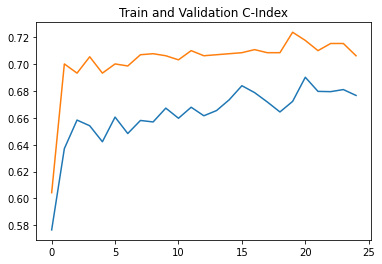

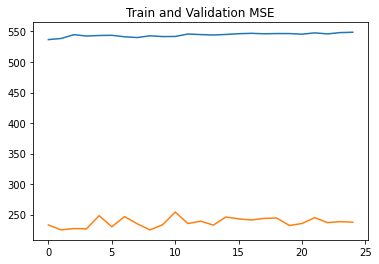

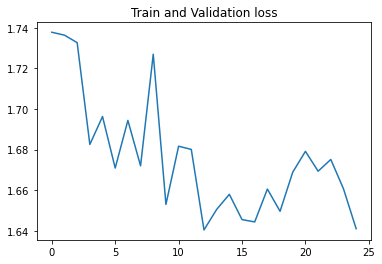

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

history = trainer.history()
plt.plot(history['train_cindices'])
plt.plot(history['val_cindices'])
plt.title('Train and Validation C-Index')
plt.show()

plt.plot(history['train_mse'])
plt.plot(history['val_mse'])
plt.title('Train and Validation MSE')
plt.show()

#plt.plot(history['train_losses'])
plt.plot(history['val_losses'])
plt.title('Train and Validation loss')
plt.show()

# Evaluation

In [12]:
trainer.evaluation(test_loader, device)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.44it/s]

0.7091675447839831


In [13]:
bst_model = trainer.get_best_model()
bst_model.to('cpu')
torch.save(bst_model.state_dict(), 'final_model.pt')